In [33]:
# 提出時は消す
import os
os.chdir('C:\\Users\\Takanori\\Desktop\\Kaggle\\TPS2204\\input')

# Introduction
Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

EDA was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-eda-fe-baseline)</br>
Pseudo Labeling was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-fe-pseudo-labels-baseline)</br>
Prediction without NN is in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-optuna-lgbm-blend)

In [34]:
import pandas as pd
import numpy as np
import warnings 

warnings.simplefilter("ignore")
# indexを指定しないと、PyCaretの予測結果がめちゃくちゃになる?
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv", index_col=['sequence', 'subject', 'step'])
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv", index_col=['sequence', 'subject', 'step'])
labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

display(train.head())
display(test.head())
display(labels.head())
display(sub.head())

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
sequence subject step                                                          
0        47      0     -0.196291   0.112395        1.0   0.329204  -1.004660   
                 1     -0.447450   0.134454        1.0  -0.658407   0.162495   
                 2      0.326893  -0.694328        1.0   0.330088   0.473678   
                 3      0.523184   0.751050        1.0   0.976991  -0.563287   
                 4      0.272025   1.074580        1.0  -0.136283   0.398579   

                       sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
sequence subject step                                                          
0        47      0     -0.131638  -0.127505   0.368702       -0.1  -0.963873   
                 1      0.340314  -0.209472  -0.867176        0.2  -0.301301   
                 2      1.280479  -0.094718   0.535878        1.4   1.002168   
                 3     -0.720269   0.793260   0.951145       -0.3  -0.995665   
                 4      0.044877   0.560109  -0.541985       -0.9   1.055636   

                       sensor_10  sensor_11  sensor_12  
sequence subject step                                   
0        47      0     -0.985069   0.531893   4.751492  
                 1      0.082733  -0.231481   0.454390  
                 2      0.449221  -0.586420  -4.736147  
                 3     -0.434290   1.344650   0.429241  
                 4      0.812631   0.123457  -0.223359

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
sequence subject step                                                          
25968    684     0      2.427357  19.639706        1.0  -1.466372  -1.289973   
                 1     -4.950541 -21.747899        1.0   0.983186  -0.569053   
                 2      1.136012 -10.756303        1.0   1.016814   0.964157   
                 3      0.806028   6.504202        1.0  -0.179646   0.969221   
                 4      1.288253   5.552521        1.0  -0.493805  -1.036124   

                       sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
sequence subject step                                                          
25968    684     0     -4.207928   2.486339  -2.493893        8.0  -1.123555   
                 1      1.845924  -3.887978   1.727481       -2.9   0.395231   
                 2      2.454749   0.312386   1.154198       -5.6   1.114162   
                 3     -1.035153  -0.457195   0.254962       -2.7  -0.588873   
                 4     -1.126402   2.008197  -0.730534        0.0   0.899566   

                       sensor_10  sensor_11  sensor_12  
sequence subject step                                   
25968    684     0     -1.673048  10.980453   0.419011  
                 1     -0.882233  -1.871399  -0.008525  
                 2      1.525273 -11.584362   0.139812  
                 3      0.608761  -4.241770  -0.462916  
                 4     -1.259615  -0.472222  -0.121483

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


# Feature Engineering

In [35]:
# 予測するものはsequence毎のstateだが、各sequenceは60stepのデータを持つため、統計量で集約する
from scipy.stats import kurtosis
def kurtosis_func(series):
    '''
    Describe something...
    '''
    return kurtosis(series)

def q01(series):
    return np.quantile(series, 0.01)

def q05(series):
    return np.quantile(series, 0.05)

def q95(series):
    return np.quantile(series, 0.95)

def q99(series):
    return np.quantile(series, 0.99)

def zero_cnt(series):
    # センサーが異常になると0を返すので、0の数をパラメータとして持たせる
    return sum(series == 0)

def make_fft_features(group):
    # 高速フーリエ変換
    from scipy.fft import rfft
    import numpy as np
    # 戻り値が複数あるので、aggregate出来ない。
    # したがって、後でjoinする
    return pd.concat(
        [pd.Series(np.abs(rfft(group[col].values)), 
                   index=[f'{col}_freq_{i}' for i in range(31)]) 
         for col in group.columns if col not in ['sequence', 'subject', 'step']
        ])

def make_subject_count(df):
    return df.groupby('subject').count()['sensor_00'].rename('subject_count')

def aggregated_features(df, aggregation_cols = ['sequence'], prefix = ''):
    agg_strategy = {}
    for i in range(13):
        sensor_name = 'sensor_' + str(i).zfill(2)
        agg_strategy[sensor_name] = ['mean', 'max', 'min', 'var', 'mad', 'sum', 'median', 'skew', kurtosis_func, q01, q05, q95, q99, zero_cnt]

    group = df.groupby(aggregation_cols).aggregate(agg_strategy)
    group.columns = ['_'.join(col).strip() for col in group.columns]
    group.columns = [str(prefix) + str(col) for col in group.columns]
    group.reset_index(inplace = True)

    fft_group = df.sort_values(['subject', 'sequence', 'step']).groupby(aggregation_cols).apply(make_fft_features)
    temp = (df.groupby(aggregation_cols).size().reset_index(name = str(prefix) + 'size'))
    group = pd.merge(temp, group, how = 'left', on = aggregation_cols,)
    group = pd.merge(group, fft_group, how = 'left', on = aggregation_cols)

    temp = make_subject_count(df)
    group = pd.merge(group, temp, how = 'left', on = 'subject')

    return group

* PyCaretを使ってみる
* https://pycaret.gitbook.io/docs/

In [36]:
# !pip install pycaret -full
import pycaret
from pycaret.classification import *
from pycaret.classification import setup, compare_models, blend_models, finalize_model, predict_model, plot_model

In [37]:
train = aggregated_features(train, aggregation_cols = ['sequence', 'subject'])
test = aggregated_features(test, aggregation_cols = ['sequence', 'subject'])

In [38]:
train.head()

,sequence,subject,size,sensor_00_mean,sensor_00_max,sensor_00_min,sensor_00_var,sensor_00_mad,sensor_00_sum,sensor_00_median,sensor_00_skew,sensor_00_kurtosis_func,sensor_00_q01,sensor_00_q05,sensor_00_q95,sensor_00_q99,sensor_00_zero_cnt,sensor_01_mean,sensor_01_max,sensor_01_min,sensor_01_var,sensor_01_mad,sensor_01_sum,sensor_01_median,sensor_01_skew,sensor_01_kurtosis_func,sensor_01_q01,sensor_01_q05,sensor_01_q95,sensor_01_q99,sensor_01_zero_cnt,sensor_02_mean,sensor_02_max,sensor_02_min,sensor_02_var,sensor_02_mad,sensor_02_sum,sensor_02_median,sensor_02_skew,sensor_02_kurtosis_func,sensor_02_q01,sensor_02_q05,sensor_02_q95,sensor_02_q99,sensor_02_zero_cnt,sensor_03_mean,sensor_03_max,sensor_03_min,sensor_03_var,sensor_03_mad,sensor_03_sum,sensor_03_median,sensor_03_skew,sensor_03_kurtosis_func,sensor_03_q01,sensor_03_q05,sensor_03_q95,sensor_03_q99,sensor_03_zero_cnt,sensor_04_mean,sensor_04_max,sensor_04_min,sensor_04_var,sensor_04_mad,sensor_04_sum,sensor_04_median,sensor_04_skew,sensor_04_kurtosis_func,sensor_04_q01,sensor_04_q05,sensor_04_q95,sensor_04_q99,sensor_04_zero_cnt,sensor_05_mean,sensor_05_max,sensor_05_min,sensor_05_var,sensor_05_mad,sensor_05_sum,sensor_05_median,sensor_05_skew,sensor_05_kurtosis_func,sensor_05_q01,sensor_05_q05,sensor_05_q95,sensor_05_q99,sensor_05_zero_cnt,sensor_06_mean,sensor_06_max,sensor_06_min,sensor_06_var,sensor_06_mad,sensor_06_sum,sensor_06_median,sensor_06_skew,sensor_06_kurtosis_func,sensor_06_q01,sensor_06_q05,sensor_06_q95,sensor_06_q99,sensor_06_zero_cnt,sensor_07_mean,sensor_07_max,sensor_07_min,sensor_07_var,sensor_07_mad,sensor_07_sum,sensor_07_median,sensor_07_skew,sensor_07_kurtosis_func,sensor_07_q01,sensor_07_q05,sensor_07_q95,sensor_07_q99,sensor_07_zero_cnt,sensor_08_mean,sensor_08_max,sensor_08_min,sensor_08_var,sensor_08_mad,sensor_08_sum,sensor_08_median,sensor_08_skew,sensor_08_kurtosis_func,sensor_08_q01,sensor_08_q05,sensor_08_q95,sensor_08_q99,sensor_08_zero_cnt,sensor_09_mean,sensor_09_max,sensor_09_min,sensor_09_var,sensor_09_mad,sensor_09_sum,sensor_09_median,sensor_09_skew,sensor_09_kurtosis_func,sensor_09_q01,sensor_09_q05,sensor_09_q95,sensor_09_q99,sensor_09_zero_cnt,sensor_10_mean,sensor_10_max,sensor_10_min,sensor_10_var,sensor_10_mad,sensor_10_sum,sensor_10_median,sensor_10_skew,sensor_10_kurtosis_func,sensor_10_q01,sensor_10_q05,sensor_10_q95,sensor_10_q99,sensor_10_zero_cnt,sensor_11_mean,sensor_11_max,sensor_11_min,sensor_11_var,sensor_11_mad,sensor_11_sum,sensor_11_median,sensor_11_skew,sensor_11_kurtosis_func,sensor_11_q01,sensor_11_q05,sensor_11_q95,sensor_11_q99,sensor_11_zero_cnt,sensor_12_mean,sensor_12_max,sensor_12_min,sensor_12_var,sensor_12_mad,sensor_12_sum,sensor_12_median,sensor_12_skew,sensor_12_kurtosis_func,sensor_12_q01,sensor_12_q05,sensor_12_q95,sensor_12_q99,sensor_12_zero_cnt,sensor_00_freq_0,sensor_00_freq_1,sensor_00_freq_2,sensor_00_freq_3,sensor_00_freq_4,sensor_00_freq_5,sensor_00_freq_6,sensor_00_freq_7,sensor_00_freq_8,sensor_00_freq_9,sensor_00_freq_10,sensor_00_freq_11,sensor_00_freq_12,sensor_00_freq_13,sensor_00_freq_14,sensor_00_freq_15,sensor_00_freq_16,sensor_00_freq_17,sensor_00_freq_18,sensor_00_freq_19,sensor_00_freq_20,sensor_00_freq_21,sensor_00_freq_22,sensor_00_freq_23,sensor_00_freq_24,sensor_00_freq_25,sensor_00_freq_26,sensor_00_freq_27,sensor_00_freq_28,sensor_00_freq_29,sensor_00_freq_30,sensor_01_freq_0,sensor_01_freq_1,sensor_01_freq_2,sensor_01_freq_3,sensor_01_freq_4,sensor_01_freq_5,sensor_01_freq_6,sensor_01_freq_7,sensor_01_freq_8,sensor_01_freq_9,sensor_01_freq_10,sensor_01_freq_11,sensor_01_freq_12,sensor_01_freq_13,sensor_01_freq_14,sensor_01_freq_15,sensor_01_freq_16,sensor_01_freq_17,sensor_01_freq_18,sensor_01_freq_19,sensor_01_freq_20,sensor_01_freq_21,sensor_01_freq_22,sensor_01_freq_23,sensor_01_freq_24,sensor_01_freq_25,sensor_01_freq_26,sensor_01_freq_27,sensor_01_freq_28,sensor_01_freq_29,sensor_01_freq_30,sensor_02_freq_0,sensor_02_freq_1,sensor_02_freq_2,...,sensor_04_freq_30,

In [39]:
# 予測対象であるstateをくっつける
train_df_label = pd.merge(train, labels, on="sequence")

In [40]:
train_df_label.tail()

,sequence,subject,size,sensor_00_mean,sensor_00_max,sensor_00_min,sensor_00_var,sensor_00_mad,sensor_00_sum,sensor_00_median,sensor_00_skew,sensor_00_kurtosis_func,sensor_00_q01,sensor_00_q05,sensor_00_q95,sensor_00_q99,sensor_00_zero_cnt,sensor_01_mean,sensor_01_max,sensor_01_min,sensor_01_var,sensor_01_mad,sensor_01_sum,sensor_01_median,sensor_01_skew,sensor_01_kurtosis_func,sensor_01_q01,sensor_01_q05,sensor_01_q95,sensor_01_q99,sensor_01_zero_cnt,sensor_02_mean,sensor_02_max,sensor_02_min,sensor_02_var,sensor_02_mad,sensor_02_sum,sensor_02_median,sensor_02_skew,sensor_02_kurtosis_func,sensor_02_q01,sensor_02_q05,sensor_02_q95,sensor_02_q99,sensor_02_zero_cnt,sensor_03_mean,sensor_03_max,sensor_03_min,sensor_03_var,sensor_03_mad,sensor_03_sum,sensor_03_median,sensor_03_skew,sensor_03_kurtosis_func,sensor_03_q01,sensor_03_q05,sensor_03_q95,sensor_03_q99,sensor_03_zero_cnt,sensor_04_mean,sensor_04_max,sensor_04_min,sensor_04_var,sensor_04_mad,sensor_04_sum,sensor_04_median,sensor_04_skew,sensor_04_kurtosis_func,sensor_04_q01,sensor_04_q05,sensor_04_q95,sensor_04_q99,sensor_04_zero_cnt,sensor_05_mean,sensor_05_max,sensor_05_min,sensor_05_var,sensor_05_mad,sensor_05_sum,sensor_05_median,sensor_05_skew,sensor_05_kurtosis_func,sensor_05_q01,sensor_05_q05,sensor_05_q95,sensor_05_q99,sensor_05_zero_cnt,sensor_06_mean,sensor_06_max,sensor_06_min,sensor_06_var,sensor_06_mad,sensor_06_sum,sensor_06_median,sensor_06_skew,sensor_06_kurtosis_func,sensor_06_q01,sensor_06_q05,sensor_06_q95,sensor_06_q99,sensor_06_zero_cnt,sensor_07_mean,sensor_07_max,sensor_07_min,sensor_07_var,sensor_07_mad,sensor_07_sum,sensor_07_median,sensor_07_skew,sensor_07_kurtosis_func,sensor_07_q01,sensor_07_q05,sensor_07_q95,sensor_07_q99,sensor_07_zero_cnt,sensor_08_mean,sensor_08_max,sensor_08_min,sensor_08_var,sensor_08_mad,sensor_08_sum,sensor_08_median,sensor_08_skew,sensor_08_kurtosis_func,sensor_08_q01,sensor_08_q05,sensor_08_q95,sensor_08_q99,sensor_08_zero_cnt,sensor_09_mean,sensor_09_max,sensor_09_min,sensor_09_var,sensor_09_mad,sensor_09_sum,sensor_09_median,sensor_09_skew,sensor_09_kurtosis_func,sensor_09_q01,sensor_09_q05,sensor_09_q95,sensor_09_q99,sensor_09_zero_cnt,sensor_10_mean,sensor_10_max,sensor_10_min,sensor_10_var,sensor_10_mad,sensor_10_sum,sensor_10_median,sensor_10_skew,sensor_10_kurtosis_func,sensor_10_q01,sensor_10_q05,sensor_10_q95,sensor_10_q99,sensor_10_zero_cnt,sensor_11_mean,sensor_11_max,sensor_11_min,sensor_11_var,sensor_11_mad,sensor_11_sum,sensor_11_median,sensor_11_skew,sensor_11_kurtosis_func,sensor_11_q01,sensor_11_q05,sensor_11_q95,sensor_11_q99,sensor_11_zero_cnt,sensor_12_mean,sensor_12_max,sensor_12_min,sensor_12_var,sensor_12_mad,sensor_12_sum,sensor_12_median,sensor_12_skew,sensor_12_kurtosis_func,sensor_12_q01,sensor_12_q05,sensor_12_q95,sensor_12_q99,sensor_12_zero_cnt,sensor_00_freq_0,sensor_00_freq_1,sensor_00_freq_2,sensor_00_freq_3,sensor_00_freq_4,sensor_00_freq_5,sensor_00_freq_6,sensor_00_freq_7,sensor_00_freq_8,sensor_00_freq_9,sensor_00_freq_10,sensor_00_freq_11,sensor_00_freq_12,sensor_00_freq_13,sensor_00_freq_14,sensor_00_freq_15,sensor_00_freq_16,sensor_00_freq_17,sensor_00_freq_18,sensor_00_freq_19,sensor_00_freq_20,sensor_00_freq_21,sensor_00_freq_22,sensor_00_freq_23,sensor_00_freq_24,sensor_00_freq_25,sensor_00_freq_26,sensor_00_freq_27,sensor_00_freq_28,sensor_00_freq_29,sensor_00_freq_30,sensor_01_freq_0,sensor_01_freq_1,sensor_01_freq_2,sensor_01_freq_3,sensor_01_freq_4,sensor_01_freq_5,sensor_01_freq_6,sensor_01_freq_7,sensor_01_freq_8,sensor_01_freq_9,sensor_01_freq_10,sensor_01_freq_11,sensor_01_freq_12,sensor_01_freq_13,sensor_01_freq_14,sensor_01_freq_15,sensor_01_freq_16,sensor_01_freq_17,sensor_01_freq_18,sensor_01_freq_19,sensor_01_freq_20,sensor_01_freq_21,sensor_01_freq_22,sensor_01_freq_23,sensor_01_freq_24,sensor_01_freq_25,sensor_01_freq_26,sensor_01_freq_27,sensor_01_freq_28,sensor_01_freq_29,sensor_01_freq_30,sensor_02_freq_0,sensor_02_freq_1,sensor_02_freq_2,...,sensor_05_freq_0,s

In [41]:
clf1 = setup(data = train_df_label,
             target = 'state',  # 目標変数
             ignore_features =['sequence'],
             numeric_imputation = 'mean',  # 欠損値は平均で補完
             fold_strategy = 'groupkfold',
             fold_groups = 'sequence',
             use_gpu = True,
             fold = 3,
             remove_outliers=True,
             normalize = True, 
             normalize_method = 'minmax',
             silent = True)

,Description,Value
0,session_id,6280
1,Target,state
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(25968, 590)"
5,Missing Values,False
6,Numeric Features,576
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [42]:
# 学習が進んできたらモデルを比較する。一旦はlightgbmでもそれなりに見れているのでこれで
# compare_models()

In [43]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8822,0.9467,0.9121,0.8643,0.8876,0.7641,0.7653
1,0.8671,0.9403,0.9050,0.8409,0.8718,0.7342,0.7364
2,0.8791,0.9475,0.9204,0.8501,0.8838,0.7582,0.7608
Mean,0.8761,0.9448,0.9125,0.8518,0.8811,0.7522,0.7541
Std,0.0065,0.0032,0.0063,0.0097,0.0067,0.0129,0.0127


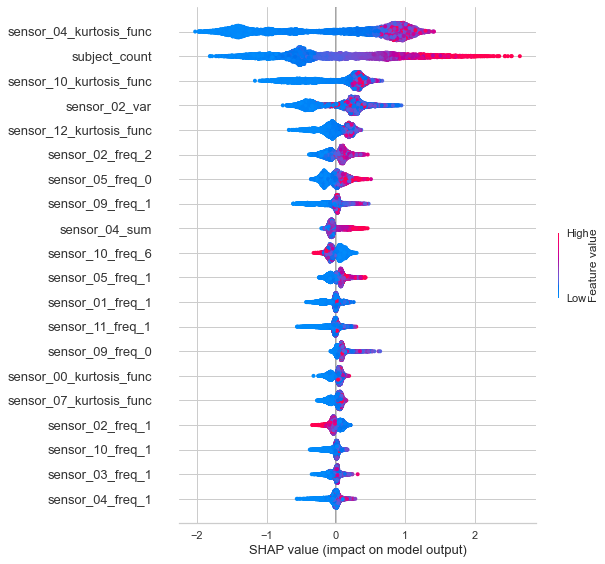

In [44]:
interpret_model(lightgbm_model)

In [45]:
final_model = finalize_model(lightgbm_model)
pred = predict_model(final_model, data=test)

In [46]:
pred.head()

,sequence,subject,size,sensor_00_mean,sensor_00_max,sensor_00_min,sensor_00_var,sensor_00_mad,sensor_00_sum,sensor_00_median,...,sensor_12_freq_24,sensor_12_freq_25,sensor_12_freq_26,sensor_12_freq_27,sensor_12_freq_28,sensor_12_freq_29,sensor_12_freq_30,subject_count,Label,Score
0,25968,684,60,-0.002602,3.146832,-4.950541,1.191898,0.732741,-0.156105,-0.002318,...,2.261977,0.812867,1.857509,6.876121,2.524938,1.248630,0.856351,4200,1,0.9239
1,25969,935,60,0.028516,5.816074,-3.675425,2.102617,0.848916,1.710974,-0.015842,...,0.464460,3.020707,4.485375,1.258047,4.676053,2.916543,2.547741,3540,1,0.8915
2,25970,924,60,0.057664,12.306028,-15.005410,25.843168,4.023308,3.459815,1.079212,...,67.521338,76.731701,32.909650,31.476051,17.284496,17.915713,25.282182,2280,0,0.9906
3,25971,769,60,-0.004791,2.876352,-2.465997,0.837073,0.687991,-0.287481,-0.033617,...,4.853194,3.453879,2.918891,0.640602,4.292754,3.055347,6.040068,4200,1,0.8533
4,25972,764,60,-0.001443,17.295209,-9.974498,7.748900,1.083572,-0.086553,-0.171947,...,49.843422,54.520331,84.945510,151.532220,64.743645,289.365524,40.291986,2940,1,0.7751


In [47]:
sub.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [48]:
pred['Label']

0        1
1        1
2        0
3        1
4        1
        ..
12213    1
12214    0
12215    1
12216    0
12217    0
Name: Label, Length: 12218, dtype: int32

In [49]:
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
sub

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0
...,...,...
12213,38181,0
12214,38182,0
12215,38183,0
12216,38184,0


In [50]:
sub['state'] = pred['Label']

In [51]:
sub.to_csv('submission.csv', index=False)
sub

,sequence,state
0,25968,1
1,25969,1
2,25970,0
3,25971,1
4,25972,1
...,...,...
12213,38181,1
12214,38182,0
12215,38183,1
12216,38184,0


In [52]:
# 欲張りモデル分析セット
evaluate_model(lightgbm_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…